<a href="https://colab.research.google.com/github/Abebayehu-Alaro/AUTOMATED-COURSE-REGISTRATION-RESULT-PROCESSING-SYSTEM/blob/master/Original_OCR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importing the libraries

> Indented block



In [555]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import os
from google.colab.patches import cv2_imshow
from google.colab import files
from sklearn import datasets
from sklearn import svm as supportVectorMachine



In [628]:
SZ=20
bin_n = 16 
affine_flags = cv.WARP_INVERSE_MAP|cv.INTER_LINEAR
count=1
countHOG=0

*Before* finding the HOG(Histogram Oreineted Gradient), as features vector, we deskew the image using its second order moments. So we first define a function deskew() which takes a digit image and deskew it. Below is the deskew() function:

In [629]:
def deskew(img):
    global count
    if count==1200:
      print("The original image")
      cv2_imshow(img)
      plt.imshow(img, cmap=plt.cm.viridis, interpolation='nearest')
      plt.show()
    m = cv.moments(img)
    if abs(m['mu02']) < 1e-2:
        return img.copy()
    skew = m['mu11']/m['mu02']
    M = np.float32([[1, skew, -0.5*SZ*skew], [0, 1, 0]])
    img = cv.warpAffine(img,M,(SZ, SZ),flags=affine_flags)
    if count==1200:
      print("The deskewed image")
      plt.imshow(img, cmap=plt.cm.plasma, interpolation='nearest')
      plt.show()
    count=count+1
    return img

Next we have to find the HOG Descriptor of each cell. For that, we find Sobel derivatives of each cell in X and Y direction. Then find their magnitude and direction of gradient at each pixel. This gradient is quantized to 16 integer values. Divide this image to four sub-squares. For each sub-square, calculate the histogram of direction (16 bins) weighted with their magnitude. So each sub-square gives you a vector containing 16 values. Four such vectors (of four sub-squares) together gives us a feature vector containing 64 values. This is the feature vector we use to train our data.

In [613]:
def hog(img):
    gx = cv.Sobel(img, cv.CV_32F, 1, 0)
    gy = cv.Sobel(img, cv.CV_32F, 0, 1)
    mag, ang = cv.cartToPolar(gx, gy)  # euclidean distance
    global countHOG
    if countHOG == 0:
      print("Magnitude: ",len(mag))
      print(mag)
      print("Orientation: ",len(ang))
      print(ang)
      countHOG=countHOG + 1

    bins = np.int32(bin_n*ang/(2*np.pi))    # quantizing binvalues in (0...16)
    bin_cells = bins[:10,:10], bins[10:,:10], bins[:10,10:], bins[10:,10:]
    mag_cells = mag[:10,:10], mag[10:,:10], mag[:10,10:], mag[10:,10:]
    hists = [np.bincount(b.ravel(), m.ravel(), bin_n) for b, m in zip(bin_cells, mag_cells)]
    hist = np.hstack(hists)     # hist is a 64 bit vector
    return hist

Making the dataset folder and importing the digits dataset

In [614]:
!mkdir uploads

mkdir: cannot create directory ‘uploads’: File exists


In [615]:
uploaded = files.upload()
uploaded_files = list(uploaded.keys())
for uploaded_file in uploaded_files:
  print(uploaded_file)
  !mv $uploaded_file uploads/$uploaded_file

In [616]:
uploads_dir = "/content/uploads/"
IMAGE_PATH = os.path.join(uploads_dir + "digits.png")

# for filename in os.listdir(uploads_dir):
#     IMAGE_PATH=os.path.join(uploads_dir, filename)



Importing the digit dataset

In [617]:
img = cv.imread(IMAGE_PATH, 0)
if img is None:
    raise Exception("The digits.png dataset required !")

We split our big dataset into individual cells. For every digit, 250 cells are reserved for training data and remaining 250 data is reserved for testing

In [618]:
cells = [np.hsplit(row,100) for row in np.vsplit(img,50)]


First half is for training and the next half is for testing 

In [619]:
train_cells = [ i[:50] for i in cells ]
test_cells = [ i[50:] for i in cells]



```
# This is formatted as code
```

Calling deskew function to deskew the given cell

The original image


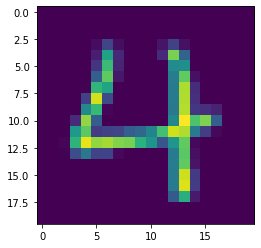

The deskewed image


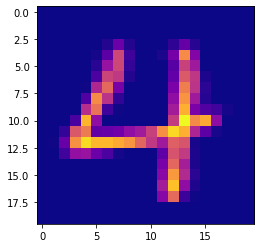

In [630]:
deskewed = [list(map(deskew,row)) for row in train_cells]

Calling the hog function to find the HOG Descriptor of each cell

In [454]:
hogdata = [list(map(hog,row)) for row in deskewed]


Magnitude:  20
[[   0.           0.           0.           0.           0.
     0.           0.           0.           0.           0.
     0.           0.           0.           0.           0.
     0.           0.           0.           0.           0.       ]
 [   0.           0.           0.           0.           0.
     0.           0.           9.899495    50.47772     77.31753
    63.560993    22.803509     2.828427     0.           0.
     0.           0.           0.           0.           0.       ]
 [   0.           0.           0.           0.           0.
     0.          25.455845   178.86867    495.02524    748.55194
   772.3134     514.29565    186.31694     22.627417     0.
     0.           0.           0.           0.           0.       ]
 [   0.           0.           0.           0.           0.
     4.2426405   99.8599     504.28763    907.2001     918.40405
   947.58746    979.30994    638.3181     161.40013      0.
     0.           0.           0.           0.

In [455]:
trainData = np.float32(hogdata).reshape(-1,64)

In [456]:
responses = np.repeat(np.arange(10),250)[:,np.newaxis]

Making ready the classfier by setting different parameters

In [457]:
svm = cv.ml.SVM_create()
svm.setKernel(cv.ml.SVM_LINEAR)
svm.setType(cv.ml.SVM_C_SVC)
svm.setC(2.67)
svm.setGamma(5.383)

Training the classfier

In [458]:
svm.train(trainData, cv.ml.ROW_SAMPLE, responses)

True

Saving the trained the classifier weight

In [459]:
svm.save('svm_data.dat')

Testing the **classfier**

In [538]:
deskewed = [list(map(deskew,row)) for row in test_cells]
hogdata = [list(map(hog,row)) for row in deskewed]
testData = np.float32(hogdata).reshape(-1,bin_n*4)
result = svm.predict(testData)[1]

Checking the Accuracy

In [539]:
mask = result==responses
correct = np.count_nonzero(mask)
print(correct*100.0/result.size)

93.84


**Testing the trained classfier**
<br>importing the single digit image

In [462]:
!mkdir test_uploads

mkdir: cannot create directory ‘test_uploads’: File exists


In [631]:
TEST_IMAGE_PATH = "/content/test_uploads/3.png"

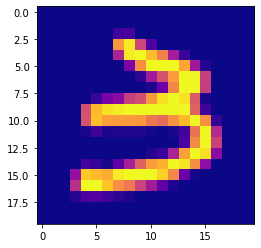

In [632]:
test_img = cv.imread(TEST_IMAGE_PATH, 0)
if test_img is None:
    raise Exception("Test image is empty")

plt.imshow(test_img, cmap=plt.cm.plasma, interpolation='nearest')
plt.show()


In [633]:
deskewed = deskew(test_img)
hogdata = hog(deskewed)
testData = np.float32(hogdata).reshape(-1,bin_n*4)
result = svm.predict(testData)[1]

Magnitude:  20
[[   0.           0.           0.           0.           0.
     0.           0.           0.           0.           0.
     0.           0.           0.           0.           0.
     0.           0.           0.           0.           0.       ]
 [   0.           0.           0.           0.          11.313708
    49.396355    80.895       70.93659     28.284271     0.
     0.           0.           0.           0.           0.
     0.           0.           0.           0.           0.       ]
 [   0.           0.           0.           0.          63.245552
   376.44653    702.0897     777.8252     528.6095     197.47404
    38.183765     0.           0.           0.           0.
     0.           0.           0.           0.           0.       ]
 [   0.           0.           0.           0.          80.399
   534.9393     733.1698     783.0773    1054.074      920.2445
   690.4201     412.0801     161.1521      29.698484     0.
     0.           0.           0.    

In [634]:
print(result)

[[3.]]


## Scikit-learn SVM classfier 

In [544]:
clf = supportVectorMachine.SVC()
clf = supportVectorMachine.SVC(gamma=0.001, C=100)
digits = datasets.load_digits()
X,y = digits.data[:-10], digits.target[:-10]
clf.fit(X,y)
print(clf.predict(digits.data[1].reshape(1,-1)))


[1]


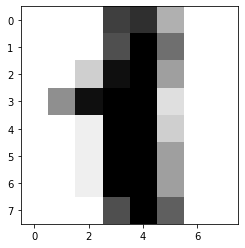

In [545]:
plt.imshow(digits.images[1], cmap=plt.cm.gray_r, interpolation='nearest')
plt.show()